In [31]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# change default figsize 
plt.rcParams['figure.figsize'] = (15, 12)

# Spatial Overlays

### This example shows a basic spatial overlay procedure. There is some filtering of the initial states layer to create a layer containing only US states. The states layer is then further filtered into three layers representing IN, KY, and OH (the tristate area) and the three layers are mapped with an overlay of the rivers layer.

In [2]:
states = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces.zip')
streams = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/physical/ne_50m_rivers_lake_centerlines.zip')

In [3]:
states.columns

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local',
       'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe',
       'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me',
       'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank',
       'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id',
       'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3',
       'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name',
       'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code',
       'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1',
       'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid',
       'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr',
       'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja',
       'name_ko', 'name_nl', 'name_pl', 'name_

In [4]:
US= states.loc[states['iso_a2'] == 'US']

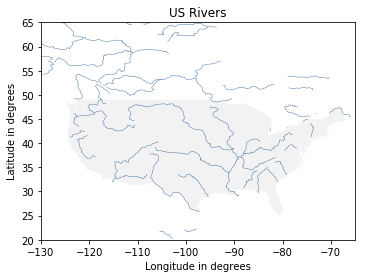

In [5]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

US.plot(ax=ax, color='#f2f2f2', zorder=0);
streams.plot(ax=ax, color='#295b97', zorder=1, linewidth=.4);


ax.set(title="US Rivers", 
       xlabel="Longitude in degrees",
       ylabel="Latitude in degrees");

ax.set(xlim=(-130,-65), ylim=(20,65));

In [6]:
IN= states.loc[states['name_nl'] == 'Indiana']
KY= states.loc[states['name_nl'] == 'Kentucky']
OH= states.loc[states['name_nl'] == 'Ohio']

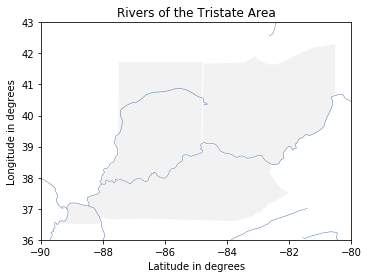

In [7]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

IN.plot(ax=ax, color='#f2f2f2', edgecolor='white', zorder=0);
KY.plot(ax=ax, color='#f2f2f2', edgecolor='white', zorder=0);
OH.plot(ax=ax, color='#f2f2f2', edgecolor='white', zorder=0);
streams.plot(ax=ax, color='#295b97', zorder=1, linewidth=.4);


ax.set(title="Rivers of the Tristate Area", 
       xlabel="Latitude in degrees",
       ylabel="Longitude in degrees");

ax.set(xlim=(-90,-80), ylim=(36,43));

# Spatial Reprojection

### This example brings in two spatial layers with different crs. The stockyards layer is reprojected to epsg:4326 to ensure a proper spatial overlay with the KY layer. The stockyards4326 layer is then exported to shapefile in epsg:4326 for further development.

In [8]:
stockyards = gpd.read_file('ftp://ftp.kymartian.ky.gov/kyag/stockyards.zip')

In [9]:
KY.crs, stockyards.crs

({'init': 'epsg:4326'},
 {'proj': 'lcc',
  'lat_1': 37.08333333333334,
  'lat_2': 38.66666666666666,
  'lat_0': 36.33333333333334,
  'lon_0': -85.75,
  'x_0': 1500000,
  'y_0': 999999.9999999999,
  'ellps': 'GRS80',
  'towgs84': '0,0,0,0,0,0,0',
  'units': 'us-ft',
  'no_defs': True})

In [10]:
stockyards4326 = stockyards.to_crs({'init': 'epsg:4326'})

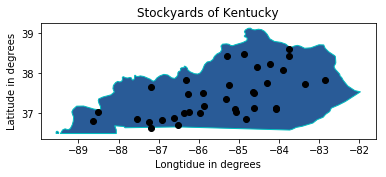

In [11]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

KY.plot(ax=ax, color='#295b97', edgecolor='c', zorder=0);
stockyards4326.plot(ax=ax, color='black', zorder=1);


ax.set(title="Stockyards of Kentucky", 
       xlabel="Longtidue in degrees",
       ylabel="Latitude in degrees");

In [12]:
stockyards4326.to_file('ky_stockyards4326')

# Clipping

### This first part of the clipping example follows along witht he method presented in the lesson that often misses several of the desired features to be clipped.

In [13]:
# Create a single polygon object for clipping
USA = US.geometry.unary_union
USstreams = streams[streams.geometry.intersects(USA)]

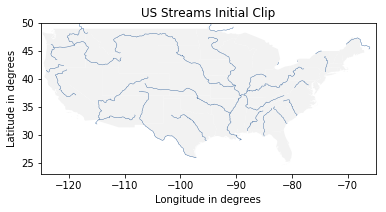

In [14]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

US.plot(ax=ax, color='#f2f2f2', zorder=0);
USstreams.plot(ax=ax, color='#295b97', zorder=1, linewidth=.4);


ax.set(title="US Streams Initial Clip", 
       xlabel="Longitude in degrees",
       ylabel="Latitude in degrees");

ax.set(xlim=(-125,-65), ylim=(23,50));

### This second part of the clipping example follows along with the lesson example to establish a spatial index which is intersected with a bounding box to provide a more accurate clip of the rivers layer.

In [15]:
# Create a single polygon object for clipping
USADIS = US.geometry.unary_union
streams_spatial_index = streams.sindex

# Create a box for the initial intersection
bbox = USADIS.bounds

# Get a list of id's for each road line that overlaps the bounding box 
# and subset the data to just those lines
sidx = list(streams_spatial_index.intersection(bbox))
streams_sub = streams.iloc[sidx]

# Clip the data - with these data
clipped = streams_sub.copy()
clipped['geometry'] = streams_sub.intersection(USADIS)

# clipped layer with no null geometry values
USstreams_cipped_2 = clipped[clipped.geometry.notnull()]

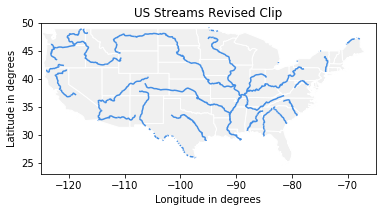

In [16]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'

US.plot(ax=ax, edgecolor='white', color=base_color)
USstreams_cipped_2.plot(ax=ax, color=line_color, zorder=1);

ax.set(title="US Streams Revised Clip", 
       xlabel="Longitude in degrees",
       ylabel="Latitude in degrees");
ax.set(xlim=(-125,-65), ylim=(23,50));

# Dissolving

### This is a quick example us dissolving a geodataframe by a common column value. This will create a single polygon of the US to overlay the rivers layer onto.

In [17]:
America = US[['iso_a2', 'geometry']]

USofA = America.dissolve(by='iso_a2')


In [18]:
America.head()

,iso_a2,geometry
49,US,(POLYGON ((-139.0565188237724 60.0015816497498...
50,US,(POLYGON ((-87.48951063106118 30.3776828146096...
51,US,POLYGON ((-89.70477194603545 36.00157341000346...
52,US,POLYGON ((-109.0478073518824 31.32787938405994...
53,US,(POLYGON ((-114.6105425494355 34.9911168284888...


In [19]:
USofA.head()

,geometry
iso_a2,
US,(POLYGON ((-155.5813247519953 19.0120183185439...


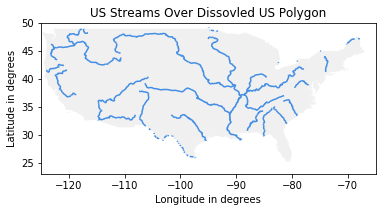

In [20]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'

USofA.plot(ax=ax, color=base_color)
USstreams_cipped_2.plot(ax=ax, color=line_color, zorder=1);

ax.set(title="US Streams Over Dissovled US Polygon", 
       xlabel="Longitude in degrees",
       ylabel="Latitude in degrees");
ax.set(xlim=(-125,-65), ylim=(23,50));

# Buffering

### This example will buffer all fayette county, kentucky parks by 5280 feet (1 mile) and clip out the address points that fall within this buffer. These homes will then be exported from the python environment into a shapefile. This example is equivalent to the challenge: Create a buffer of US rails, roads, or streams and complete find the toxic sites (or another dataset of potentially hazardous point data sites) with X distance of these line features.

In [21]:
fayette = gpd.read_file('https://data.lexingtonky.gov/dataset/197200e4-8e85-40c1-a317-3a5abc7ce634/resource/bf745aa3-1210-412a-9243-f4d0e9f53f57/download/county.zip')
parks  =gpd.read_file('https://data.lexingtonky.gov/dataset/f69e0e32-95a5-486f-afb0-970db7b2df1a/resource/1390c679-df7b-4160-94b8-732ba5fd4cff/download/park.zip')
homes = gpd.read_file('https://data.lexingtonky.gov/dataset/726565ad-3e19-4e60-9ada-d742b0c39b55/resource/6af62514-4e93-4b14-98ca-e7010febe3a5/download/addresspoint.zip')

In [22]:
fayette.crs, parks.crs, homes.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [23]:
# since we want to measure distances, play it safe and project the data to an equidistant conic projection
lex_homes= homes.to_crs({'init': 'epsg:3089'})
lex_parks= parks.to_crs({'init': 'epsg:3089'})
county= fayette.to_crs({'init': 'epsg:3089'})

In [24]:
#create a new column and assign it the result of the buffer operation
lex_parks['buffer'] = lex_parks.buffer(5280)
# note they are now polygons in feet
lex_parks['buffer'].head()

0    POLYGON ((5271479.459211862 3884491.248152442,...
1    POLYGON ((5276978.751142669 3880178.77871999, ...
2    POLYGON ((5272310.555369862 3885020.328142852,...
3    POLYGON ((5275902.195994228 3881398.009942264,...
4    POLYGON ((5283136.86307755 3906591.245523585, ...
Name: buffer, dtype: object

In [25]:
bounds=county.bounds
print(bounds)

           minx          miny          maxx          maxy
0  5.235256e+06  3.834225e+06  5.343926e+06  3.967584e+06


In [26]:
lex_parks = lex_parks.set_geometry('buffer')
lex_parkz= lex_parks.geometry.unary_union
mile_to_park = lex_homes[lex_homes.geometry.intersects(lex_parkz)]

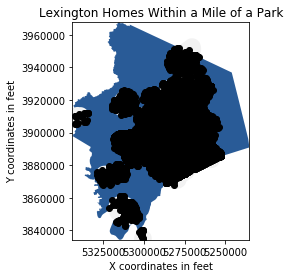

In [27]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

county.plot(ax=ax, color='#295b97', zorder=0);
lex_parks.plot(ax=ax, color='#f2f2f2', zorder=1, linewidth=.4);
mile_to_park.plot(ax=ax, color='black', zorder=2);

ax.set(title="Lexington Homes Within a Mile of a Park", 
       xlabel="X coordinates in feet",
       ylabel="Y coordinates in feet");
ax.set(xlim=(5.343926e+06,5.235256e+06), ylim=(3.834225e+06 ,3.967584e+06));

In [32]:
mile_to_park.columns

Index(['OBJECTID', 'STADD', 'STDIR', 'STNAME', 'STTYPE', 'UNIT', 'TYPE',
       'STFULLNAME', 'NEWDATE', 'UPDATE_', 'ADDRESS', 'Active', 'Retired',
       'Source', 'created_by', 'last_edite', 'geometry'],
      dtype='object')

In [37]:
lex_ky_mile_to_park = mile_to_park[['geometry']]

In [38]:
lex_ky_mile_to_park.to_file('lex_ky_mile_to_park')

# GeoPandas Overlay function (Intersectin, Union, Symmetrical Difference, Difference, etc)

In [30]:
=gpd.read_file('')
=gpd.read_file('')

SyntaxError: invalid syntax (<ipython-input-30-1b31a3daa56f>, line 1)

In [ ]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

.plot(ax=ax, color='#295b97', zorder=0);
.plot(ax=ax, color='#f2f2f2', zorder=1, linewidth=.4);
.plot(ax=ax, color='#ffe5cb', zorder=2);
.plot(ax=ax, color='orange', zorder=3, markersize=8);

ax.set(title="World map", 
       xlabel="X coordinates in degrees",
       ylabel="Y coordinates in degrees");

## For merge and join example see previously produced geopandas example notebook at: https://github.com/newmapsplus/map674-module-03-ljmoser83/blob/master/Merge_Join.ipynb

## For previously produced example showing how to load tile tayers for backgrounds see: https://github.com/newmapsplus/map674-module-04-ljmoser83/blob/master/geopandas.ipynb

## For a previously produced walktrhough of general geopandas plotting methods and data management see: https://github.com/newmapsplus/map674-module-04-ljmoser83/blob/master/geopandas2.ipynb